In [3]:
import re
import time
import psycopg2
import pandas as pd
from tqdm import tqdm
import geopy.distance
import matplotlib.pyplot as plt
import pickle

### Connect to database

In [4]:
conn = psycopg2.connect(
    host="localhost",
    database="krakow_90",
    user="postgres",
    password="postgres")

In [5]:
conn.autocommit = True
cursor = conn.cursor() 

### Get result helper function

In [6]:
def get_results(cursor):  
    result = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]

    print(columns)

    for row in result:
        print(row)

### Check data size and number of records

In [8]:
size_query = "SELECT pg_size_pretty( pg_database_size('krakow_distance') ); "

records_nb_query = "SELECT COUNT(*) FROM edge_table;"

In [9]:
cursor.execute(records_nb_query)
get_results(cursor)

In [10]:
cursor.execute(size_query)
get_results(cursor)

### Plotting function

In [7]:
def plot_query_times(query_times, save=False, filepath=None):
    query_nb = [i for i in range(1, len(query_times) + 1)]
    plt.plot(query_nb, query_times, marker=".", color="teal")
    plt.xlabel("Query number")
    plt.ylabel("Query execution time [ms]")
    
    if save:
        plt.show()
        plt.savefig(filepath, bbox_inches="tight", dpi=200)
        plt.close()
        
    else:
        plt.show()

### Nodes selection

In [12]:
# # two random osmid
# distance_small = 0
# osmid_1_small = 0
# osmid_2_small = 0

# while distance_small < 25:
#     start_and_finish = nodes.sample(2)

#     osmid_1_small = int(start_and_finish.iloc[0]["osmid"])
#     osmid_2_small = int(start_and_finish.iloc[1]["osmid"])

#     coords_1 = start_and_finish.iloc[0]["y"], start_and_finish.iloc[0]["x"]
#     coords_2 = start_and_finish.iloc[1]["y"], start_and_finish.iloc[1]["x"]
    
#     distance_small = geopy.distance.distance(coords_1, coords_2).km

# print(f"osmid_1_small: {osmid_1_small}, osmid_2_small: {osmid_2_small}, distance: {distance_small} km")

In [8]:
osmid_1_short = 262220894
osmid_2_short = 6949642867

osmid_1_long = 4538716538
osmid_2_long = 432648629

### Paths queries and parsing query time

## Dijkstra

In [31]:
dijkstra_benchmark_short_undirected = f"""
    EXPLAIN ANALYZE 
    SELECT * FROM pgr_dijkstra(
    'SELECT id, source, target, length as cost, length as reverse_cost FROM edge_table',
    {osmid_1_short}, {osmid_2_short},
    directed => false);
"""

dijkstra_benchmark_short_directed = f"""
    EXPLAIN ANALYZE
    SELECT * FROM pgr_dijkstra(
    'SELECT id, source, target, length as cost FROM edge_table',
    {osmid_1_short}, {osmid_2_short},
    directed => true);
"""

dijkstra_benchmark_long_undirected = f"""
    EXPLAIN ANALYZE 
    SELECT * FROM pgr_dijkstra(
    'SELECT id, source, target, length as cost, length as reverse_cost FROM edge_table',
    {osmid_1_long}, {osmid_2_long},
    directed => false);
"""

dijkstra_benchmark_long_directed = f"""
    EXPLAIN ANALYZE 
    SELECT * FROM pgr_dijkstra(
    'SELECT id, source, target, length as cost FROM edge_table',
    {osmid_1_long}, {osmid_2_long},
    directed => true);
"""


## Astar

In [9]:
astar_benchmark_short_undirected = f"""
    EXPLAIN ANALYZE
    SELECT * FROM pgr_aStar(
    'SELECT id, source, target, length as cost, length as reverse_cost, x1, y1, x2, y2 FROM edge_table',
    {osmid_1_short}, {osmid_2_short},
    directed => false);
"""

astar_benchmark_short_directed = f"""
    EXPLAIN ANALYZE
    SELECT * FROM pgr_aStar(
    'SELECT id, source, target, length as cost, x1, y1, x2, y2 FROM edge_table',
    {osmid_1_short}, {osmid_2_short},
    directed => true);
"""

astar_benchmark_long_undirected = f"""
    EXPLAIN ANALYZE
    SELECT * FROM pgr_aStar(
    'SELECT id, source, target, length as cost, length as reverse_cost, x1, y1, x2, y2 FROM edge_table',
    {osmid_1_long}, {osmid_2_long},
    directed => false);
"""

astar_benchmark_long_directed = f"""
    EXPLAIN ANALYZE
    SELECT * FROM pgr_aStar(
    'SELECT id, source, target, length as cost, x1, y1, x2, y2 FROM edge_table',
    {osmid_1_long}, {osmid_2_long},
    directed => true);
"""

In [10]:
def parse_query_time(cursor):
    result = cursor.fetchall()
    time = int(re.findall("\d+", result[-1][0])[0])
    return time

# Short distance

### How many queries

In [11]:
query_number = 10

### dijkstra short distance, directed

Query: 100%|██████████| 15/15 [09:31<00:00, 38.13s/it]


queries times: [33016, 33510, 32682, 32076, 31709, 32475, 33363, 33400, 33330, 33286, 33395, 33406, 33299, 34026, 33827]


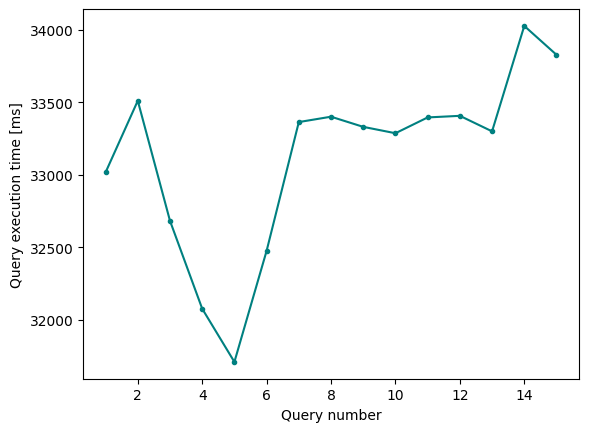

In [107]:
dijkstra_short_directed_query_times_psql = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(dijkstra_benchmark_short_directed)
    dijkstra_short_directed_query_times_psql.append(parse_query_time(cursor))
    time.sleep(5)
    
print(f"queries times: {dijkstra_short_directed_query_times_psql}")

plot_query_times(dijkstra_short_directed_query_times_psql)

pickle.dump(dijkstra_short_directed_query_times_psql, open( "./results/krakow_120/dijkstra_short_directed_query_times_psql.bin", "wb" ) )


### dijkstra short distance, undirected

Query: 100%|██████████| 15/15 [07:33<00:00, 30.25s/it]


queries times: [25370, 23820, 24049, 24649, 24750, 24979, 24988, 25144, 25606, 25518, 25896, 25511, 25827, 26187, 26232]


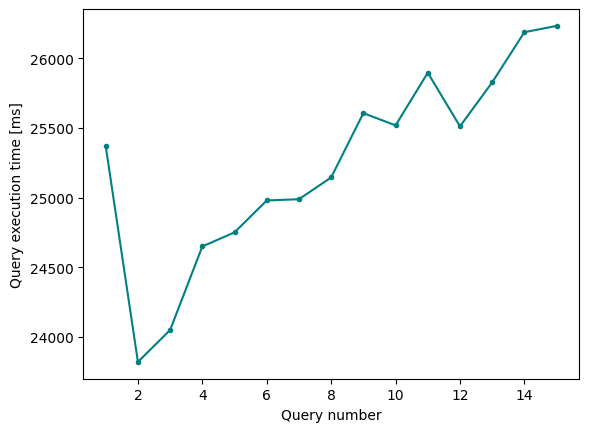

In [110]:
dijkstra_short_undirected_query_times_psql = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(dijkstra_benchmark_short_undirected)
    dijkstra_short_undirected_query_times_psql.append(parse_query_time(cursor))
    time.sleep(5)
    
print(f"queries times: {dijkstra_short_undirected_query_times_psql}")

plot_query_times(dijkstra_short_undirected_query_times_psql)

pickle.dump(dijkstra_short_undirected_query_times_psql, open( "./results/krakow_120/dijkstra_short_undirected_query_times_psql.bin", "wb" ) )


### Astar short distance, directed

In [ ]:
query_number = 15

Query:   0%|          | 0/10 [00:00<?, ?it/s]

Query: 100%|██████████| 10/10 [10:26<00:00, 62.63s/it]


queries times: [82004, 47601, 49712, 46165, 50467, 51309, 57725, 50310, 56338, 54443]


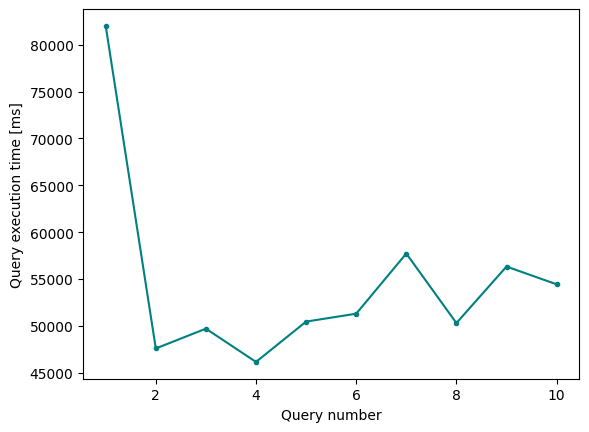

In [12]:
astar_short_directed_query_times_psql = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(astar_benchmark_short_directed)
    astar_short_directed_query_times_psql.append(parse_query_time(cursor))
    time.sleep(8)
    
print(f"queries times: {astar_short_directed_query_times_psql}")

plot_query_times(astar_short_directed_query_times_psql)

pickle.dump(astar_short_directed_query_times_psql, open( "./results/krakow_90/astar_short_directed_query_times_psql.bin", "wb" ) )


### Astar short distance, undirected

Query:   0%|          | 0/15 [00:00<?, ?it/s]

Query: 100%|██████████| 15/15 [08:28<00:00, 33.87s/it]


queries times: [31002, 29810, 30002, 30434, 32373, 31659, 33490, 33957, 34688, 34606, 35025, 35614, 35464, 40096, 37535]


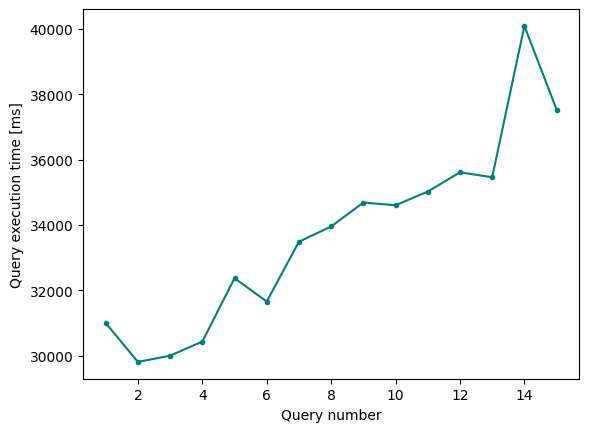

In [116]:
astar_short_undirected_query_times_psql = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(astar_benchmark_short_undirected)
    astar_short_undirected_query_times_psql.append(parse_query_time(cursor))
    time.sleep(0.1)
    
print(f"queries times: {astar_short_undirected_query_times_psql}")

plot_query_times(astar_short_undirected_query_times_psql)

pickle.dump(astar_short_undirected_query_times_psql, open( "./results/krakow_120/astar_short_undirected_query_times_psql.bin", "wb" ) )


# Long distance

In [54]:
query_number = 15

### dijkstra long distance, directed

Query: 100%|██████████| 15/15 [21:28<00:00, 85.93s/it]


queries times: [78016, 80028, 81905, 81655, 80734, 81731, 83236, 83149, 84446, 84686, 85850, 86614, 87969, 89034, 89795]


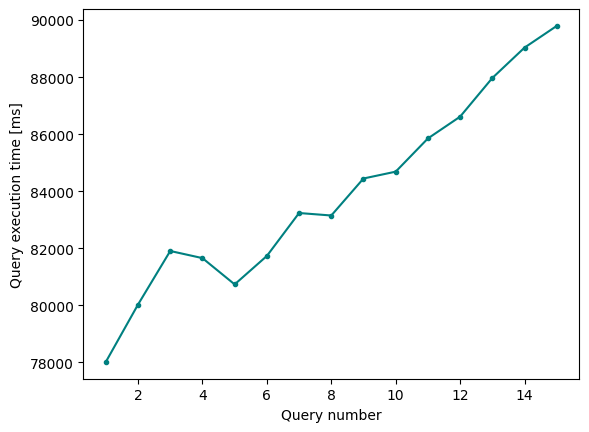

In [125]:
dijkstra_long_directed_query_times_psql = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(dijkstra_benchmark_long_directed)
    dijkstra_long_directed_query_times_psql.append(parse_query_time(cursor))
    time.sleep(2)
    
print(f"queries times: {dijkstra_long_directed_query_times_psql}")

plot_query_times(dijkstra_long_directed_query_times_psql)

pickle.dump(dijkstra_long_directed_query_times_psql, open( "./results/krakow_120/dijkstra_long_directed_query_times_psql.bin", "wb" ) )


### dijkstra long distance, undirected

Query: 100%|██████████| 15/15 [14:55<00:00, 59.67s/it]


queries times: [53026, 55737, 52216, 52132, 53421, 53836, 54172, 54129, 54833, 55911, 55294, 55854, 56409, 56466, 56553]


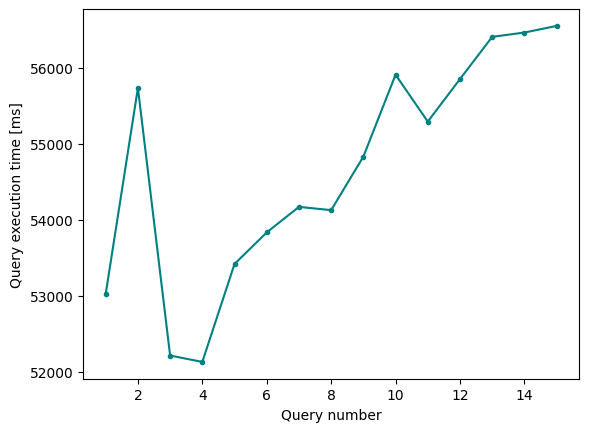

In [131]:
dijkstra_long_undirected_query_times_psql = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(dijkstra_benchmark_long_undirected)
    dijkstra_long_undirected_query_times_psql.append(parse_query_time(cursor))
    time.sleep(5)
    
print(f"queries times: {dijkstra_long_undirected_query_times_psql}")

plot_query_times(dijkstra_long_undirected_query_times_psql)

pickle.dump(dijkstra_long_undirected_query_times_psql, open( "./results/krakow_120/dijkstra_long_undirected_query_times_psql.bin", "wb" ) )


### Astar long distance, directed

Query: 100%|██████████| 15/15 [09:15<00:00, 37.05s/it]

queries times: [33217, 33184, 33221, 33951, 34476, 35575, 37572, 37566, 38109, 38553, 39055, 39486, 39995, 39978, 40150]


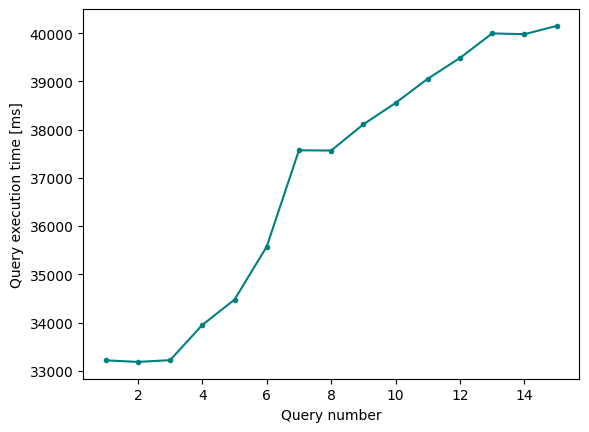

In [63]:
astar_long_directed_query_times_psql = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(astar_benchmark_long_directed)
    astar_long_directed_query_times_psql.append(parse_query_time(cursor))
    time.sleep(5)
    
print(f"queries times: {astar_long_directed_query_times_psql}")

plot_query_times(astar_long_directed_query_times_psql)

pickle.dump(astar_long_directed_query_times_psql, open( "./results/krakow_120/astar_long_directed_query_times_psql.bin", "wb" ) )


### Astar long distance, undirected

In [128]:
astar_long_undirected_query_times_psql = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(astar_benchmark_long_undirected)
    astar_long_undirected_query_times_psql.append(parse_query_time(cursor))
    time.sleep(5)
    
print(f"queries times: {astar_long_undirected_query_times_psql}")

plot_query_times(astar_long_undirected_query_times_psql)

pickle.dump(astar_long_undirected_query_times_psql, open( "./results/krakow_120/astar_long_undirected_query_times_psql.bin", "wb" ) )

Query:   0%|          | 0/15 [00:08<?, ?it/s]


InternalError_: BŁĄD:  invalid memory alloc request size 1080000000
CONTEXT:  funkcja SQL "pgr_astar" wyrażenie 1


In [58]:
conn.commit() 
conn.close() 

## save results

In [ ]:
pickle.dump(dijkstra_short_directed_query_times_psql, open( "./results/krakow_120/dijkstra_short_directed_query_times_psql.bin", "wb" ) )
pickle.dump(dijkstra_short_undirected_query_times_psql, open( "./results/krakow_120/dijkstra_short_undirected_query_times_psql.bin", "wb" ) )
pickle.dump(astar_short_directed_query_times_psql, open( "./results/krakow_120/astar_short_directed_query_times_psql.bin", "wb" ) )
pickle.dump(astar_short_undirected_query_times_psql, open( "./results/krakow_120/astar_short_undirected_query_times_psql.bin", "wb" ) )

pickle.dump(dijkstra_long_directed_query_times_psql, open( "./results/krakow_120/dijkstra_long_directed_query_times_psql.bin", "wb" ) )
pickle.dump(dijkstra_long_undirected_query_times_psql, open( "./results/krakow_120/dijkstra_long_undirected_query_times_psql.bin", "wb" ) )
pickle.dump(astar_long_directed_query_times_psql, open( "./results/krakow_120/astar_long_directed_query_times_psql.bin", "wb" ) )
pickle.dump(astar_long_undirected_query_times_psql, open( "./results/krakow_120/astar_long_undirected_query_times_psql.bin", "wb" ) )


# dijkstra_short_directed_query_times_psql
# dijkstra_short_undirected_query_times_psql
# astar_short_directed_query_times_psql
# astar_short_undirected_query_times_psql

# dijkstra_long_directed_query_times_psql
# dijkstra_long_undirected_query_times_psql
# astar_long_directed_query_times_psql
# astar_long_undirected_query_times_psql